In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy.stats

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

In [ ]:
dt = pd.read_csv('GeoFusionDT.csv') 

Verificando se o arquivo foi alimentado corretamente

In [ ]:
dt.head()

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501.0,932515.0
1,3304557138,Acari,Rio de Janeiro,RJ,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931.0,588833.0
2,3304557057,Água Santa,Rio de Janeiro,RJ,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391.0,874200.0
3,3304557031,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,1072,538,660,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727.0,912226.0
4,3304557125,Anchieta,Rio de Janeiro,RJ,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380.0,553020.0


Variável alvo Faturamento

In [ ]:
(dt['faturamento'].describe().round(2))

count        160.00
mean      876159.97
std       438210.60
min        24651.00
25%       711278.50
50%       824228.50
75%       934320.75
max      2915612.00
Name: faturamento, dtype: float64

# Informações sobre o dataset

Temos 160 bairros diferentes da cidade do Rio de janeiro.

In [ ]:
dt.nunique()

codigo          160
nome            160
cidade            1
estado            1
população       159
popAte9         159
popDe10a14      159
popDe15a19      156
popDe20a24      158
popDe25a34      160
popDe35a49      159
popDe50a59      159
popMaisDe60     157
domiciliosA1     41
domiciliosA2    106
domiciliosB1    153
domiciliosB2    155
domiciliosC1    158
domiciliosC2    159
domiciliosD     143
domiciliosE     158
rendaMedia      146
faturamento     160
dtype: int64


6 Valores ausentes em 'rendaMedia'

In [ ]:
dt.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   codigo        160 non-null    int64  
 1   nome          160 non-null    object 
 2   cidade        160 non-null    object 
 3   estado        160 non-null    object 
 4   população     160 non-null    int64  
 5   popAte9       160 non-null    int64  
 6   popDe10a14    160 non-null    int64  
 7   popDe15a19    160 non-null    int64  
 8   popDe20a24    160 non-null    int64  
 9   popDe25a34    160 non-null    int64  
 10  popDe35a49    160 non-null    int64  
 11  popDe50a59    160 non-null    int64  
 12  popMaisDe60   160 non-null    int64  
 13  domiciliosA1  160 non-null    int64  
 14  domiciliosA2  160 non-null    int64  
 15  domiciliosB1  160 non-null    int64  
 16  domiciliosB2  160 non-null    int64  
 17  domiciliosC1  160 non-null    int64  
 18  domiciliosC2  160 non-null    

Verificando quais os bairros estão com dados ausentes na coluna Renda média por domicílio ('rendaMedia')

iloc  -  Bairro

6    -   Anil

26   -  Catumbi

52   -   Freguesia (Jacarepaguá)

71   -   Jacaré

89   -   Maracanã

122  -   Rio Comprido


In [ ]:
NaRenda = dt[dt.isna().any(axis=1)]

In [ ]:
NaRenda

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento
6,3304557082,Anil,Rio de Janeiro,RJ,24855,2427,1227,1777,1804,3730,5573,3556,4761,355,759,1771,1863,1902,1155,326,424,NaN,1092081.0
26,3304557005,Catumbi,Rio de Janeiro,RJ,12910,1773,805,1018,999,1985,2526,1516,2288,0,18,261,640,1281,1140,229,703,NaN,791170.0
52,3304557086,Freguesia (Jacarepaguá),Rio de Janeiro,RJ,72501,7991,3709,5257,5159,10923,16875,9607,12980,698,2569,6042,4941,5055,3919,704,1670,NaN,1297388.0
71,3304557146,Jacaré,Rio de Janeiro,RJ,9538,1326,629,763,712,1547,1921,1108,1532,0,15,161,492,633,792,197,540,NaN,822849.0
89,3304557032,Maracanã,Rio de Janeiro,RJ,25969,1696,843,1370,1921,4020,5134,4124,6861,739,1695,3191,1924,1522,877,0,497,NaN,1384873.0
122,3304557006,Rio Comprido,Rio de Janeiro,RJ,44998,5332,2397,3448,3757,7160,9375,5527,8002,0,387,2119,2775,3715,3930,617,1681,NaN,789463.0


#Feature Engineering

Tomei a decisão de encontrar fontes e preencher valores para os dados faltantes, evitando a necessidade de deletar as amostras com dados faltantes
(dt.dropna(inplace=True)) de um dataset pequeno. 

Os valores para renda média por domicílio aferidos a partir da renda per capita disponibilizados pela FGV em:

https://cps.fgv.br/r-renda-capita-populacao-total-e-favelas-bairros-rio-de-janeiro

Este valor é multiplicado por 2.9, que é média de habitantes por domicílio de acordo com o IBGE :

https://sidra.ibge.gov.br/tabela/6578


No caso dos bairros que não estão explicitamente descritos foram utilizados os valores de bairros proximos já presentes no dataset

Rio Comprido e Catumbi- Centro

Jacaré - Rocha 



In [ ]:
dt.at[6,'rendaMedia'] = (1535*2.9)
dt.at[26,'rendaMedia'] = 2186         # Centro
dt.at[52,'rendaMedia'] = (1658*2.9)
dt.at[71,'rendaMedia'] = 2667         # Rocha
dt.at[89,'rendaMedia'] = (2447*2.9)
dt.at[122,'rendaMedia'] = 2186        # Centro

In [ ]:
dt.loc[[52]] #Verificando 1 entrada

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento
52,3304557086,Freguesia (Jacarepaguá),Rio de Janeiro,RJ,72501,7991,3709,5257,5159,10923,16875,9607,12980,698,2569,6042,4941,5055,3919,704,1670,4808.2,1297388.0


Outros dados gerais, como média, desvio padrão, valores mínimo, máximo.

In [ ]:
dt.describe()

,codigo,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento
count,1.600000e+02,160.000000,160.00000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.00000,160.000000,160.000000,1.600000e+02
mean,3.304557e+09,42654.350000,5329.06250,2484.443750,3272.156250,3349.381250,6584.475000,8826.862500,5332.262500,7475.706250,388.475000,608.268750,1871.562500,2385.075000,3539.850000,3030.806250,568.37500,1821.612500,3618.987500,8.761600e+05
std,4.633213e+01,64262.949072,10816.19977,4948.827166,5752.156303,5601.893201,9049.895783,11536.276416,7986.261929,10258.307743,1403.605232,1535.237669,2973.530791,2779.071565,4324.539462,4003.047836,823.92034,2292.079295,5985.930278,4.382106e+05
min,3.304557e+09,173.000000,33.00000,13.000000,22.000000,17.000000,28.000000,38.000000,10.000000,12.000000,0.000000,0.000000,0.000000,0.000000,5.000000,3.000000,0.00000,2.000000,654.000000,2.465100e+04
25%,3.304557e+09,13362.750000,1512.75000,690.750000,945.000000,994.750000,2131.250000,2900.750000,1598.750000,2118.250000,0.000000,0.000000,391.500000,716.000000,1088.750000,789.750000,117.75000,431.500000,1498.000000,7.112785e+05
50%,3.304557e+09,26076.000000,3111.50000,1434.000000,2015.000000,2142.500000,4170.500000,5657.000000,3371.500000,4575.500000,0.000000,107.500000,848.000000,1536.000000,2394.500000,1861.500000,327.50000,1042.500000,1944.000000,8.242285e+05
75%,3.304557e+09,46504.500000,5622.25000,2621.500000,3448.750000,3451.750000,7145.250000,9586.750000,6333.250000,9196.000000,1.000000,430.500000,1962.500000,3065.750000,4203.000000,3652.500000,694.00000,2138.250000,2986.750000,9.343208e+05
max,3.304557e+09,667603.000000,122578.00000,55935.000000,62342.000000,60567.000000,86116.000000,105316.000000,83341.000000,91408.000000,13408.000000,11668.000000,19350.000000,21237.000000,33111.000000,25779.000000,4956.00000,14833.000000,63887.000000,2.915612e+06


Chama a atenção alguns valores, como o população total (menor bairro com  173 pessoas e maior 667.603).

Ainda que valores muito distantes podem afetar os modelos de regressão, os valores por faixa etária são validados pela coluna 'população'. Por isso irei manter os dados de população por faixa etária sem nenhum tipo de censura (Trimming ou Winsorização).	

In [ ]:
dt['PopDiff'] = dt['população']-(dt['popAte9']+dt['popDe10a14']
+dt['popDe15a19']+dt['popDe20a24']+dt['popDe25a34']+dt['popDe35a49']
+dt['popDe50a59']+dt['popMaisDe60'])

In [ ]:
dt['PopDiff'].describe()

count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: PopDiff, dtype: float64

In [ ]:
dt.describe()

,codigo,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,PopDiff
count,1.600000e+02,160.000000,160.00000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.00000,160.000000,160.000000,1.600000e+02,160.0
mean,3.304557e+09,42654.350000,5329.06250,2484.443750,3272.156250,3349.381250,6584.475000,8826.862500,5332.262500,7475.706250,388.475000,608.268750,1871.562500,2385.075000,3539.850000,3030.806250,568.37500,1821.612500,3618.987500,8.761600e+05,0.0
std,4.633213e+01,64262.949072,10816.19977,4948.827166,5752.156303,5601.893201,9049.895783,11536.276416,7986.261929,10258.307743,1403.605232,1535.237669,2973.530791,2779.071565,4324.539462,4003.047836,823.92034,2292.079295,5985.930278,4.382106e+05,0.0
min,3.304557e+09,173.000000,33.00000,13.000000,22.000000,17.000000,28.000000,38.000000,10.000000,12.000000,0.000000,0.000000,0.000000,0.000000,5.000000,3.000000,0.00000,2.000000,654.000000,2.465100e+04,0.0
25%,3.304557e+09,13362.750000,1512.75000,690.750000,945.000000,994.750000,2131.250000,2900.750000,1598.750000,2118.250000,0.000000,0.000000,391.500000,716.000000,1088.750000,789.750000,117.75000,431.500000,1498.000000,7.112785e+05,0.0
50%,3.304557e+09,26076.000000,3111.50000,1434.000000,2015.000000,2142.500000,4170.500000,5657.000000,3371.500000,4575.500000,0.000000,107.500000,848.000000,1536.000000,2394.500000,1861.500000,327.50000,1042.500000,1944.000000,8.242285e+05,0.0
75%,3.304557e+09,46504.500000,5622.25000,2621.500000,3448.750000,3451.750000,7145.250000,9586.750000,6333.250000,9196.000000,1.000000,430.500000,1962.500000,3065.750000,4203.000000,3652.500000,694.00000,2138.250000,2986.750000,9.343208e+05,0.0
max,3.304557e+09,667603.000000,122578.00000,55935.000000,62342.000000,60567.000000,86116.000000,105316.000000,83341.000000,91408.000000,13408.000000,11668.000000,19350.000000,21237.000000,33111.000000,25779.000000,4956.00000,14833.000000,63887.000000,2.915612e+06,0.0


Entretanto na coluna 'rendaMedia' temos um outlier que apresenta valor de renda domiciliar média de R$ 63.887, mais de 10x a média (que inclui o mesmo). 

Filtrando os bairros que apresentam renda média domiciliar acima de 15.000 reais, temos somente 7 bairros e nenhum desses ultrapassa a marca de 20.000 reais

R$ 63.887 é um valor claramente fora de linha e irreal. 

Aplicarei as fontes e lógica utilizadas no tratamento de valores ausentes para tratar esse outlier

In [ ]:
dt.loc[dt['rendaMedia'] > 15000]

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,PopDiff
9,3304557131,Barra Da Tijuca,Rio de Janeiro,RJ,139761,13038,5225,7432,8627,21914,32089,21058,30378,13408,11668,14820,5205,3437,1841,0,3897,18084.0,2915612.0,0
56,3304557023,Gávea,Rio de Janeiro,RJ,16455,1210,546,869,1162,2518,3307,2575,4268,1343,1173,1766,979,776,457,0,311,16449.0,1430429.0,0
68,3304557019,Ipanema,Rio de Janeiro,RJ,43948,3061,1311,1957,2395,5854,8665,6344,14361,4213,3432,4478,2323,2141,1369,117,1460,17188.0,1962438.0,0
75,3304557022,Jardim Botânico,Rio de Janeiro,RJ,18517,1602,664,945,1008,2788,4135,2822,4553,1641,1273,1913,1108,815,361,0,289,17984.0,1491476.0,0
79,3304557129,Joá,Rio de Janeiro,RJ,842,61,29,35,46,131,192,132,216,79,59,57,33,7,8,0,20,17659.0,1162364.0,0
80,3304557021,Lagoa,Rio de Janeiro,RJ,21795,1794,708,1054,1252,2943,4812,3594,5638,2916,2140,1931,697,365,306,0,469,63887.0,1775547.0,0
131,3304557025,São Conrado,Rio de Janeiro,RJ,11290,885,500,661,726,1464,2463,1741,2850,939,956,744,418,432,356,37,207,17650.0,1330747.0,0


In [ ]:
dt.at[80,'rendaMedia'] = (5635*2.9)

In [ ]:
dt.loc[[80]] #Verificando

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,PopDiff
80,3304557021,Lagoa,Rio de Janeiro,RJ,21795,1794,708,1054,1252,2943,4812,3594,5638,2916,2140,1931,697,365,306,0,469,16341.5,1775547.0,0


#Deletando *features* não necessárias

['codigo'] - Código na base SQL

['cidade'] - Somente a cidade do Rio de Janeiro na base

['estado'] - Somente o estado Rio de Janeiro

['população'] - Somatória das colunas de população por faixa etária

['PopDiff'] - Coluna criada para checagem

Por se tratar de um dataset bem pequeno (160 linhas), tentarei agrupar e eliminar o maior número de features (colunas) possíveis afim de evitar um overfitting dos modelos

In [ ]:
del dt['codigo']
del dt['cidade']
del dt['estado']
del dt['PopDiff']
del dt['população']

In [ ]:
dt['Jovens'] = (dt['popAte9']
        +dt['popDe10a14']+dt['popDe15a19'])

In [ ]:
del dt['popAte9']
del dt['popDe10a14']
del dt['popDe15a19']

In [ ]:
dt['Adultos'] = (dt['popDe20a24']
        +dt['popDe25a34']+dt['popDe35a49'])

In [ ]:
del dt['popDe20a24']
del dt['popDe25a34']
del dt['popDe35a49']

In [ ]:
dt['Idosos'] = (dt['popDe50a59']
        +dt['popMaisDe60'])

In [ ]:
del dt['popDe50a59']
del dt['popMaisDe60']

# Tratando a variável não numérica



Novamente com o intuito de evitar o aumento de *features* e ocasionar um overfitting, agruparei os bairros em 3 categorias de renda.

Os municípios foram categorizados pela renda média domiciliar sendo o primeiro quartil (25%) como baixa renda e no ultimo quartil como alta renda.

In [ ]:
def renda(rendaMedia):
    if rendaMedia > 3000 :
        return 3           #'Alta Renda'
    elif rendaMedia < 1500 :
        return 1           #'Baixa Renda'
    else :
        return 2           #'Media Renda'

In [ ]:
dt['FaixaRenda'] = dt['rendaMedia'].apply(renda)
del dt['nome']

Como os bairros foram agrupados em renda, este tera uma forte correlação com a quantidade de domicílios de Renda A1, A2, B1(...). 

Por isso vou eliminar essas *features*

In [ ]:
#dt['domiciliosA'] = dt['domiciliosA1']+dt['domiciliosA2']
#dt['domiciliosB'] = dt['domiciliosB1']+dt['domiciliosB2']
#dt['domiciliosC'] = dt['domiciliosC1']+dt['domiciliosC2']

In [ ]:
#del dt['domiciliosA']
#del dt['domiciliosB']
#del dt['domiciliosC']

In [ ]:
del dt['domiciliosA1']
del dt['domiciliosA2']
del dt['domiciliosB1']
del dt['domiciliosB2']
del dt['domiciliosC1']
del dt['domiciliosC2']
del dt['domiciliosD']
del dt['domiciliosE']

#Correlação entre as variáveis 

Mapa de calor

In [ ]:
corr_var = dt.corr().round(2)

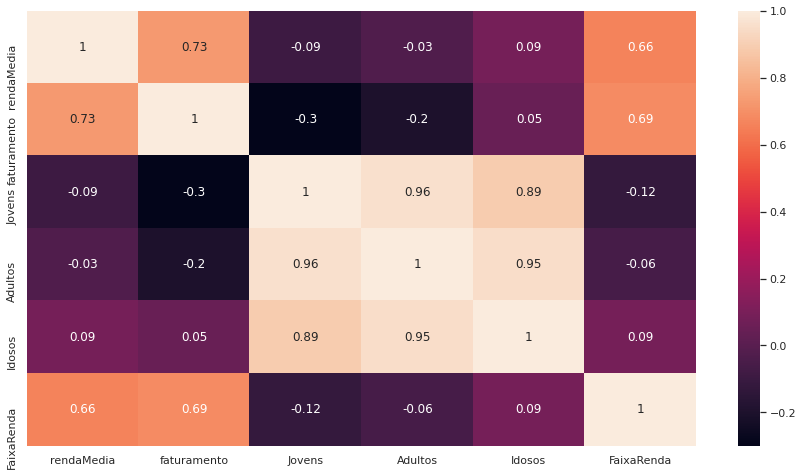

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.heatmap(data=corr_var, annot=True) 

As colunas de população total apresenta os dados consolidados da população por faixa etária. Essa *feature* será eliminada.

In [ ]:
dt.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rendaMedia   160 non-null    float64
 1   faturamento  160 non-null    float64
 2   Jovens       160 non-null    int64  
 3   Adultos      160 non-null    int64  
 4   Idosos       160 non-null    int64  
 5   FaixaRenda   160 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 7.6 KB


In [ ]:
dt.head()

,rendaMedia,faturamento,Jovens,Adultos,Idosos,FaixaRenda
0,2501.0,932515.0,2198,4775,4703,2
1,931.0,588833.0,10016,12748,4800,1
2,2391.0,874200.0,1879,4593,2531,2
3,3727.0,912226.0,2270,4009,3327,3
4,1380.0,553020.0,16343,25532,15347,1


#Train/Test split 

70% do dataset em treino, 30% em teste. Semente aleatória travada

In [ ]:
y = dt['faturamento']
del dt['faturamento']
x = dt

In [ ]:
#70/30 teste treino
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

#Padronização das variáveis numéricas

In [ ]:
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

#Regressão Linear

In [ ]:
lr= LinearRegression()

In [ ]:
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred= lr.predict(x_test)

In [ ]:
print('RMSE (Treino)', np.sqrt(mean_squared_error(y_train, lr.predict(x_train))))

RMSE (Treino) 147006.97987735533


In [ ]:
lr.score(x_train, y_train)

0.8382054536577668

In [ ]:
print('RMSE (Teste)', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE (Teste) 209147.18452717183


In [ ]:
lr.score(x_test, y_test)

0.8562222817180214

A Regressão Linear apresentou um erro médio de 209.147 reais em teste e um score alto (>0.8).

Considerando que a variável alvo tem um desvio padrão é de 438.210 e média 876.159, a regressão linear se mostrou um modelo adequado para esse problema com esse dataset.

A aplicação de modelos mais robustos (Decision Tree, Random Forest...) se mostra desnecessária e simplesmente ocasionaria um overfitting nos modelos.

Seria ideal obter uma série temporal desses dados para que modelos mais robustos pudessem ser utilizados. 